# Construction d'un modèle de machine learning pour prédire le désabonnement des clients d'une entreprise( customer churn) # 

## Importation des librairies

In [282]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact,interactive, fixed,interact_manual
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE


## Importation des données

In [35]:
df=pd.read_csv("/Users/lenovo/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()                

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Inspection de la dataframe df 

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


on a ici un problème de classification car la variable cible prend deux valeurs yes: "désabonnement" et NO: "pas de désabonnement".Il s'agit du machine learning supervisé.c'est une variable catégorielle car elle est binaire(variable qualitative).

on veut connaitre le nombre de valeurs uniques distinctes qu'on a au niveau de chaque colonne.

In [37]:
# Nombres de valeurs unique par colonne
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Etant donné que la variable customerID( identifiant du client)à 7043 VALEURS DISTINCTES, et que la dataframe contient au total 7043 LIGNES,ca veut dire que (chaque ligne réprésente un client) alors nous sommes convaicus que chaque ligne de la dataframe représente unique client.Aussi chaque variable représenteune une caractéristique distincte d'un client.

# Analyse exploratoire des données

commencons cette anayse exploratoire des données en tracant un graphique de visualisations de la distribution pour chacune des variables

In [39]:
# varaibles catégorielles
categorical_columns=df.nunique()[df.nunique() < 5].keys().to_list()
categorical_columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [43]:
# création d'une fonction de construction de graphique à barre pour chaque variable et de manière interactive
def bar_plot(a):
    df[a].value_counts(normalize=True).plot(kind="bar")
    plt.ylabel("proportion")
    plt.title("Disttibution of"+ str(a))
    return plt.show()

In [44]:
# Interact
interact(bar_plot, a=categorical_columns);

interactive(children=(Dropdown(description='a', options=('gender', 'SeniorCitizen', 'Partner', 'Dependents', '…

vous pouvez interagir avec le notebook en sélectionnant la variable catégorielle qui vous intéresse afin de visualiser sa distribution à travers le graphique à barre. Voici quelques informations que l'on peut tirer des graphiques à barres ci-dessus:

# . IL Y' a plus de clients qui ne se sont pas désabonnés ( plus de 70%) que les clients qui se sont abonnés(moins de 30%).Donc nous avons un problème de déséquilibre qu'il faut absolument résoudre car cela peut affecter les performances de notre modèle de classification que nous allons construire.
# . La distribution des données entre les différents sexes est à peu près également réparties

# . Le nombre de clients qui sont des personnes agées est( moins de 20%)  est inférieur à celui des clients jeunes(plus de 80%)

# . La variable partner indique si le client a un partenaire (YES) ou (NO).Les deux catégories ont pratiquement la meme proportion.

Répétons le meme processus cette fois-ci pour les variables numériques

In [46]:
# Echantillonnement aléatoire  de la variable  "Totalcharges"

Apparemment c'est à cause de la présence d'espacement au niveau "Totalcharges" que pandas la considère comme une variable avec des
valeurs de type objet(chaine de caractère).
Donc nous allonsremplacerces espaces par des NAN( not a number) et transformer le type de ces objets en float(décimal).

In [77]:
df["TotalCharges"].sample(10)

1096      580.1
3640     2745.2
6459    1459.35
3498     3198.6
1082           
4627     7049.5
4796     5276.1
2094      391.7
904      5398.6
4833     806.95
Name: TotalCharges, dtype: object

on exécuté maintes fois pour trouver la ligne(1082) 
qui présente l'espace conduisant àce que pandas considére la variable "Totalcharges"
 comme étant un type objet.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [89]:
# varaibles quantitatives

numerical_columns=["tenure", "MonthlyCharges",  "TotalCharges"]

# création d'une fonction de construction d'histogramme  pour chaque variable numérique et de manière interactive
def hist_plot(b):
    sns.displot(df[b], kde=False)
    plt.title("Histogram of"+ str(b))
    return plt.show()


# Conversion du type de la variable "TotalCharges" en décimal(float)
df["TotalCharges"]=df["TotalCharges"].replace(' ', np.nan).astype(float)


In [91]:
interact(hist_plot, b= numerical_columns);

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

la variable est asymétrique étalé vers la droite.

In [88]:
# coefficient d'asymétrie de la variable 'TotalCharges'

In [93]:
df["TotalCharges"].skew()

0.961642499724251

le coefficient d'asymétrie est trop élévé, ce qui montre que la variable est très asymétrique.

pour une loi normale le coefficient d'asymétrie est égal=0
pour des distributions pseudo normale la distribution est autour de zéro   

# création d'une fonction de construction de boite à moustache pour chaque variable numérique et de manière interactive

In [95]:
def box_plot(b):
    sns.boxplot(y=df[b])
    plt.title("Boxplot" + str(b))
    return plt.show()
    

In [96]:
# Interact
interact(box_plot, b= numerical_columns);

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

Nous remarquons que ces variables continues bien que ne présentant pas de valeurs abérrantes sont très asymétriques
ce qui peut causer des erreurs sur notre modeles que nous allons construire.

Nous pouvons appliquer des fonctions de transformation à ces variables afin de les rendres moins asymétriques

Nous avons une compréhension de la distribution de chaque variable au niveau de notre ensemble de données.

Maintenant faisons une analyse Bivariée

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


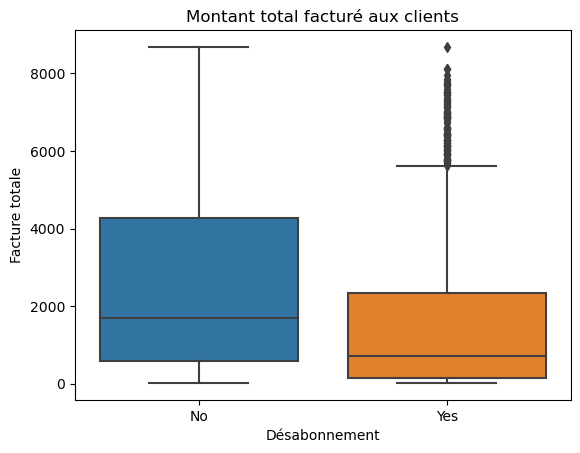

In [99]:
# TotalCharges vs churn
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.xlabel("Désabonnement")
plt.ylabel("Facture totale")
plt.title('Montant total facturé aux clients')
plt.show()

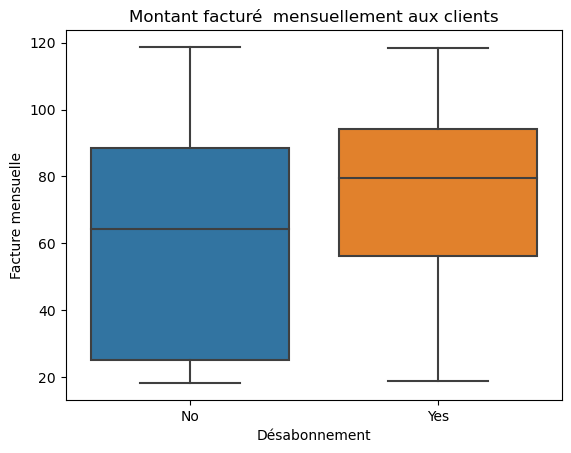

In [100]:
# MonthlyCharges vs churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.xlabel("Désabonnement")
plt.ylabel("Facture mensuelle")
plt.title('Montant facturé  mensuellement aux clients')
plt.show()

Le montant total facturé aux clients qui ont résilié leur contrat est inférieur au  montant total facturé ceux qui ne l'ont pas fait.
# Mais les clients qui se sont désabonnés sont plus facturés mensuellement que les clients qui ne se sont pas désabonnés.

cette information est très importante pour l'entreprise, car le montant facturé mensuellement peut etre un facteur important pour déterminer si un client va se désabonner ou pas.

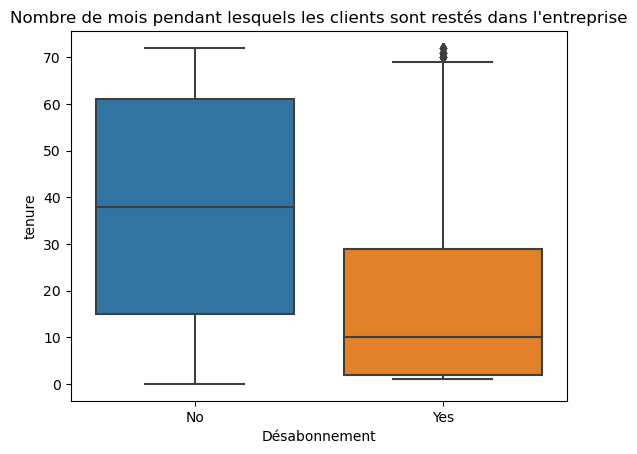

In [102]:
# tenure vs churn
sns.boxplot(x='Churn', y='tenure', data=df)
plt.xlabel("Désabonnement")
plt.title("Nombre de mois pendant lesquels les clients sont restés dans l'entreprise")
plt.show()

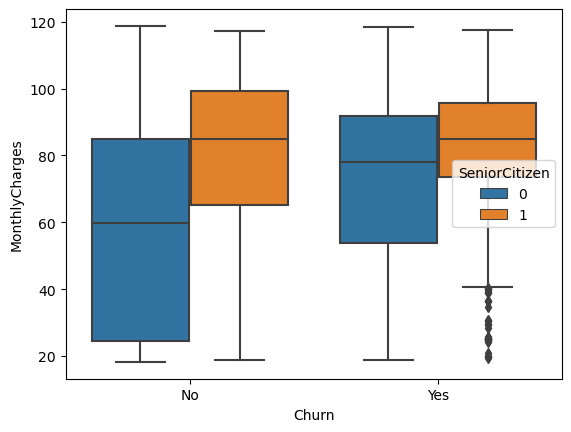

In [104]:
# MonthlyCharges vs churn by SeniorCitizen 
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, hue="SeniorCitizen");

Il semble que les personnes agées soient beaucoup plus facturés mensuellement que les jeunes.Malgré cela il reste plus fidèle à l'entreprise  que les jeunes

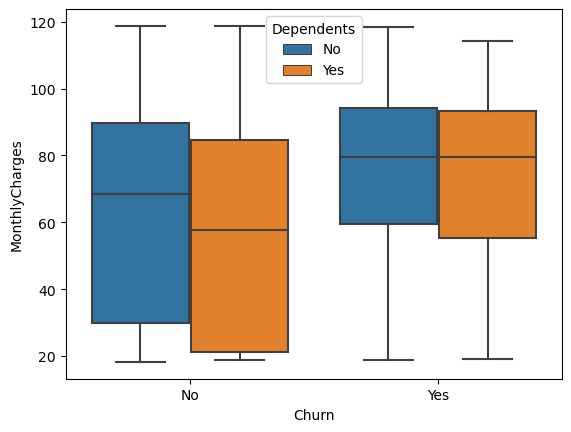

In [105]:
# MonthlyCharges vs churn by Dependents
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, hue="Dependents");


In [106]:
# résumé statistique
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


comme vous l'avez remarqué les trois variables quantitatifs( tenure ,MonthlyCharge ,TotalCharges).
On différent échelle tenure varie de 0 0 72 tandis que MonthlyCharges varie entre 18.25 et 118.75 et TotalCharges
varies entre 18.8 et 8684.8. De nombre modèle de machine et deep learning fonctionne avec des variables standardisées ou normalisées.

Nous traiterons la standardisatons des données dans la section de prétraitement des données.

# prétraitement des données #

In [109]:
# Gestion des valeurs manquantes
data= df.copy()
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
la colonne TotalCharges prrésente 11 valeurs manquantes


In [110]:
11/7043

0.001561834445548772

DONT on a 0% de toute la quantité disponible, on peut la supprimer car les valeurs manquantes sont très infériuer

In [113]:
# suppression des valeurs manquantes
data.dropna(inplace=True)

vérifions s'il y' a encore de valeurs manquantes

In [114]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

La deuxième chose que nous allons faire pour préparer les données pour la modélisation est  l'encodage des variables catégorielles

In [115]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [117]:
# Encodzge des variables binaires
data["gender"]=data["gender"].apply(lambda row : 1 if row=="female" else 0)

binary_columns=data.drop("gender", axis=1).nunique()[data.drop("gender", axis=1).nunique() < 3].keys().to_list()
binary_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [118]:
for column in binary_columns:
    data[column]=data[column].apply(lambda row : 1 if row=="Yes" else 0)

In [120]:
# Encodage des variables Catégorielle restante: celle qui contient plus de 2 valeurs distinctes

remaining_cat_vars=data[categorical_columns].nunique()[data[categorical_columns].nunique() > 2].keys().to_list()

remaining_cat_vars_dummies=pd.get_dummies(data=data[remaining_cat_vars], columns=remaining_cat_vars, drop_first=True)

In [121]:
# Nouvelle dataframe
data=pd.concat([ data["gender"], data[binary_columns], remaining_cat_vars_dummies,data[numerical_columns]], axis=1)


In [122]:
# Affichage de la nouvelle dataframe
data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,29.85,29.85
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,34,56.95,1889.50
2,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1,2,53.85,108.15
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,45,42.30,1840.75
4,0,0,0,0,1,1,1,0,0,1,...,0,0,0,0,0,1,0,2,70.70,151.65


In [123]:
data.shape

(7032, 31)

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int64  
 1   SeniorCitizen                          7032 non-null   int64  
 2   Partner                                7032 non-null   int64  
 3   Dependents                             7032 non-null   int64  
 4   PhoneService                           7032 non-null   int64  
 5   PaperlessBilling                       7032 non-null   int64  
 6   Churn                                  7032 non-null   int64  
 7   MultipleLines_No phone service         7032 non-null   uint8  
 8   MultipleLines_Yes                      7032 non-null   uint8  
 9   InternetService_Fiber optic            7032 non-null   uint8  
 10  InternetService_No                     7032 non-null   uint8  
 11  Onli

Nous avons vu que la variable TotalCharges est très asymétrique ,alors transformons là par une fonction racine carrée

In [148]:
# Transformation de la variable 'TotalCharges'

data["TotalCharges"]=np.sqrt(data["TotalCharges"])
data["TotalCharges"]

0       1.003322
1       1.007394
2       1.004584
3       1.007369
4       1.004916
          ...   
7038    1.007446
7039    1.008733
7040    1.005727
7041    1.005607
7042    1.008662
Name: TotalCharges, Length: 7032, dtype: float64

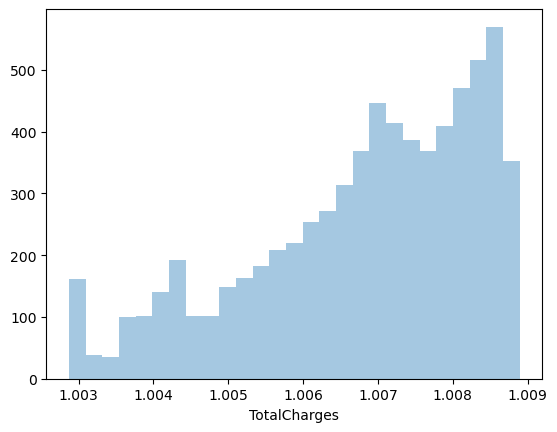

In [151]:
# Histogramme de la variable transformée
sns.distplot(data["TotalCharges"], kde=False);

In [152]:
# Coeffiecient d'asymétrie  de la variable 'TotalCharges' après transformation
data["TotalCharges"].skew()

-0.7509686060271484

In [256]:
# Données d'entrainement 60%, données de validation 20%, test20%
X= data.drop("Churn", axis=1)

y= data["Churn"]

seed=1111

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.4, random_state=seed, stratify= y)

X_val, X_test, y_val, y_test= train_test_split(X_test, y_test, test_size=0.5, random_state=seed, stratify= y_test)

il faut s'assurer que les proportions des personnes ayant résiliées leur contrat soient les memes dans les différents ensemble de données.

In [257]:
# Fréquence des classes dans y
pd.DataFrame(y).value_counts(normalize=True)

Churn
0        0.734215
1        0.265785
dtype: float64

In [258]:
# Fréquence des classes dans y_train
pd.DataFrame(y_train).value_counts(normalize=True)


Churn
0        0.734297
1        0.265703
dtype: float64

In [259]:
# Fréquence des classes dans y_val
pd.DataFrame(y_val).value_counts(normalize=True)

Churn
0        0.733997
1        0.266003
dtype: float64

In [261]:
# Fréquence des classes dans y_test
pd.DataFrame(y_test).value_counts(normalize=True)


Churn
0        0.734186
1        0.265814
dtype: float64

Attaquons nous maintenant au problème de déséquilibre de classe.

Lorsqu'il y'a une très grande différence entre le nombre d'observation dans chaque catégorie de la variable à prédire cela peut entrainer 
des erreurs de modélisation.

Dans notre cas ici , il y'a un peu plus de 73% de personnes qui n'ont pas résilié leur abonnement contre un plus de 26% qui ont résilié leur abonnement.Il y'a donc un déséquilibre de classe, on peut donc utiliser le réechantillonnage pour créer plus d'équilibre entre les catégories de la variable cible.Soit on créee plus d'observation dans la classe minoritaire(modalité 1) c'est-à-dire on fait le sur-échantillonnage, soit on diminue les observations de la classe majoritaire(sous-échantillonnage)


In [262]:
#  résolution du problème de désèquilibre de classe: Méthode de sur-échantionnage de la classse minoritaire
X2= X_train

X2["Churn"]= y_train.values

minority= X2[X2.Churn == 1]

majority= X2[X2.Churn == 0]

minority_upsampled = resample(minority, replace=True, n_samples= len(majority), random_state= seed)
                             
upsampled = pd.concat([majority, minority_upsampled], axis=0)
upsampled                             
                             

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
6406,0,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,39,50.65,1.007403,0
6124,0,0,1,1,1,1,0,0,0,0,...,0,1,0,0,0,1,57,59.30,1.007935,0
4051,0,0,1,0,1,1,0,1,1,0,...,1,0,1,1,0,0,72,97.70,1.008665,0
3839,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,1,15,20.05,1.005533,0
2523,0,0,1,1,1,0,0,0,0,1,...,0,0,1,1,0,0,47,20.25,1.006636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,0,0,0,1,1,1,0,0,1,0,...,0,0,0,0,1,0,1,69.65,1.004153,1
6040,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,70.75,1.004168,1
4212,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,90.60,1.004411,1
508,0,0,1,1,1,1,0,1,1,0,...,0,0,0,0,1,0,6,80.50,1.006093,1


In [263]:
# Vérification
upsampled["Churn"].value_counts(normalize=True)

0    0.5
1    0.5
Name: Churn, dtype: float64

notre variable ciable est déja équilibré

In [264]:
# Données d'entrainnement sur la base de la méthode se sur-échantillonnage de la classe minoritaire

X_train_up= upsampled.drop("Churn", axis=1)

y_train_up= upsampled["Churn"]

In [265]:
#  résolution du problème de désèquilibre de classe: Méthode de sous-échantionnage de la classse majoritaire

majority_downsampled= resample(majority, replace=False, n_samples= len(minority), random_state= seed)

downsampled=pd.concat([minority, majority_downsampled])

downsampled

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
6908,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,9,55.35,1.005983,1
1530,0,0,1,1,1,0,0,0,1,0,...,1,0,0,1,0,0,2,90.00,1.005137,1
3617,0,0,1,0,0,1,1,0,0,0,...,1,0,0,0,1,0,18,48.35,1.006562,1
6800,0,0,1,0,1,0,0,0,1,0,...,1,1,0,0,0,1,14,105.95,1.007063,1
3772,0,0,1,0,1,1,0,0,1,0,...,1,0,0,0,1,0,1,95.00,1.004457,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,0,0,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,71,109.25,1.008779,0
3663,0,0,0,0,1,1,0,0,1,0,...,1,0,0,0,0,1,9,88.40,1.006535,0
5033,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,1,19.40,1.002900,0
2183,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,2,50.20,1.004594,0


In [266]:
X_train_down= downsampled.drop("Churn", axis=1)

y_train_down= downsampled["Churn"]

In [267]:
# y_train et X_train

y_train= X_train["Churn"]

X_train=X_train.drop("Churn", axis=1)

In [268]:
# Définition des données d'entrainement
# choix possible: ( y_train et X_train), (X_train_up et y_train_up) et (X_train_down et y_train_down)

train_features= X_train_up

train_labels= y_train_up

Passons finalement la normalisation des données


In [269]:
train_features.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
6406,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,1,0,0,39,50.65,1.007403
6124,0,0,1,1,1,1,0,0,0,0,...,0,0,1,0,0,0,1,57,59.30,1.007935
4051,0,0,1,0,1,1,0,1,1,0,...,0,1,0,1,1,0,0,72,97.70,1.008665
3839,0,0,1,1,1,0,0,0,0,1,...,1,0,0,0,0,0,1,15,20.05,1.005533
2523,0,0,1,1,1,0,0,0,0,1,...,1,0,0,1,1,0,0,47,20.25,1.006636


In [ ]:
# c'est par ici qu'on peut commencer à améliorer les performances de notre modele

In [270]:
# Normalisation des variables indépendantes des différents ensembles de données

# Vous pouvez choisir de standardiser au lieu de normaliser. # on peut choisir StandardScaler()

scaler= MinMaxScaler()

mod_scaler= scaler.fit(train_features)
train_features= mod_scaler.transform(train_features)
X_val= mod_scaler.transform(X_val)
X_test= mod_scaler.transform(X_test)


In [271]:
# Retransformation en Dataframe
train_features= pd.DataFrame(train_features,  columns=X.columns)
X_val=pd.DataFrame(X_val, columns=X.columns)
X_test= pd.DataFrame(X_test, columns=X.columns)


In [ ]:
# Toutes les valeurs sont maintenat entre 0 et 1

In [272]:
train_features.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
count,6196.0,6196.0,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,...,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,0.0,0.0,0.438509,0.248870,0.904939,0.650904,0.095061,0.439638,0.530826,0.166720,...,0.166720,0.413331,0.165752,0.168496,0.186572,0.419787,0.205939,0.377363,0.496667,0.621765
std,0.0,0.0,0.496244,0.432393,0.293323,0.476723,0.293323,0.496383,0.499089,0.372756,...,0.372756,0.492471,0.371888,0.374336,0.389599,0.493564,0.404419,0.337783,0.287344,0.259557
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056338,0.269652,0.444068
50%,0.0,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281690,0.563682,0.669198
75%,0.0,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.676056,0.724876,0.838602
max,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Toutes les valeurs( à partir de  min et max) sont maintenat entre 0 et 1

Nous avons terminé le prétraitement des données passons maintenant à la modélisation

# Modélisation

quelle métrique choisir pour l' évaluation de la performance des modèles

vous devez préablement comprendre ce qu'on appelle la matrice de confusion

La matrice de confusion est la matrice carrée qui rapporte le nombre de vrai positif(True positif ou TP), 
vrai négatif(True Négatif ou TN), Faux positif(False positif ou FP ) et Faux négatif(False Negatif ou FN).

Dans notre cas le positif c'est 1 : le client s'est désabonné et le négatif c'est 0 le client ne s'est pas désabonné.

# TP: le client s'est désabonné et le modèle prédit qu'il s'est désabonné

# TN: le client ne s'est pas désabonné et le modèle prédit qu'il ne s'est pas désabonné

les 2 cas(TP et TN) ci-dessus sont les bons cas et (FP et FN) sont les mauvais cas

# FP: le client ne s'est pas désabonné et le modèle prédit qu'il s'est désabonné

# FN: le client  s'est  désabonné et le modèle prédit qu'il ne s'est pas désabonné


Les choix des métriques: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

# accuracy : La précision globale du modèle(accuracy en anglais) est la proportion de prévision correctes, c'est-à-dire
la somme de nombres de vrais positifs et vrai négatifs divisée par le nombre total d'observations. Elle se calcul donc avec la formule
ci-dessous:
accuracy= (TP + TN)/ ( FN+ FP+ TN + TP)

Il faut faire attention avec la précision globale. Une forte précision ne signifie pas forcement que le modèle est performant.
Le choix de la métrique pour quantifier la performance du modèle doit se faire en fonction du contexte de l'étude, c'est-à-dire la problématique qu'on veut résoudre

Lorsqu'il y'a un déséquilibre de classe, la précision globale n'est pas une bonne métrique d'évaluation de la performance du modèle
Précision et recall sont des métriques très utiliseés, surtout lorsque les classes de la variables cibles sont très déséquilibrées

# précision  est l'indicateur qui vous indique sur tous les points positifs préditifs, combien étaient de vrais positifs
               #précision# = (TP)/ (TP + FP)
               
# recall: cette métrique montre la capacité du modèle à identifer tous les vrais positifs.

               #recall#= (TP)/ (TP + FN)
               
L'amélioration de précision diminue recall et vice-versa. Alors quoi faire?

Fort heuresementil y'a une métrique qui tient compte à la fois de la sensibilité et la spécifité.C'est le F1 score

F1 SCORE :MOYENNE HARMONIQUE DE PRECISION et de RECALL.Elle se calcul donc par formule:
                       F1 score= 2* [ (precision)(recall)/ (precision +recall)      ]
                       
                       
                       
pour un modèle parfait f1 score est égal à 1 et la plus mauvaise performance est un modèle avec un f1 score égale à 0    


Nous choississons le F1 score pour évaluer la performance de chaque modèle qui sera conduit.

In [273]:
# Selon des meilleures variables prédictrices
rf= RandomForestClassifier()
rf.fit(train_features, train_labels)

print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1032
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1406
   macro avg       0.70      0.69      0.69      1406
weighted avg       0.76      0.77      0.76      1406



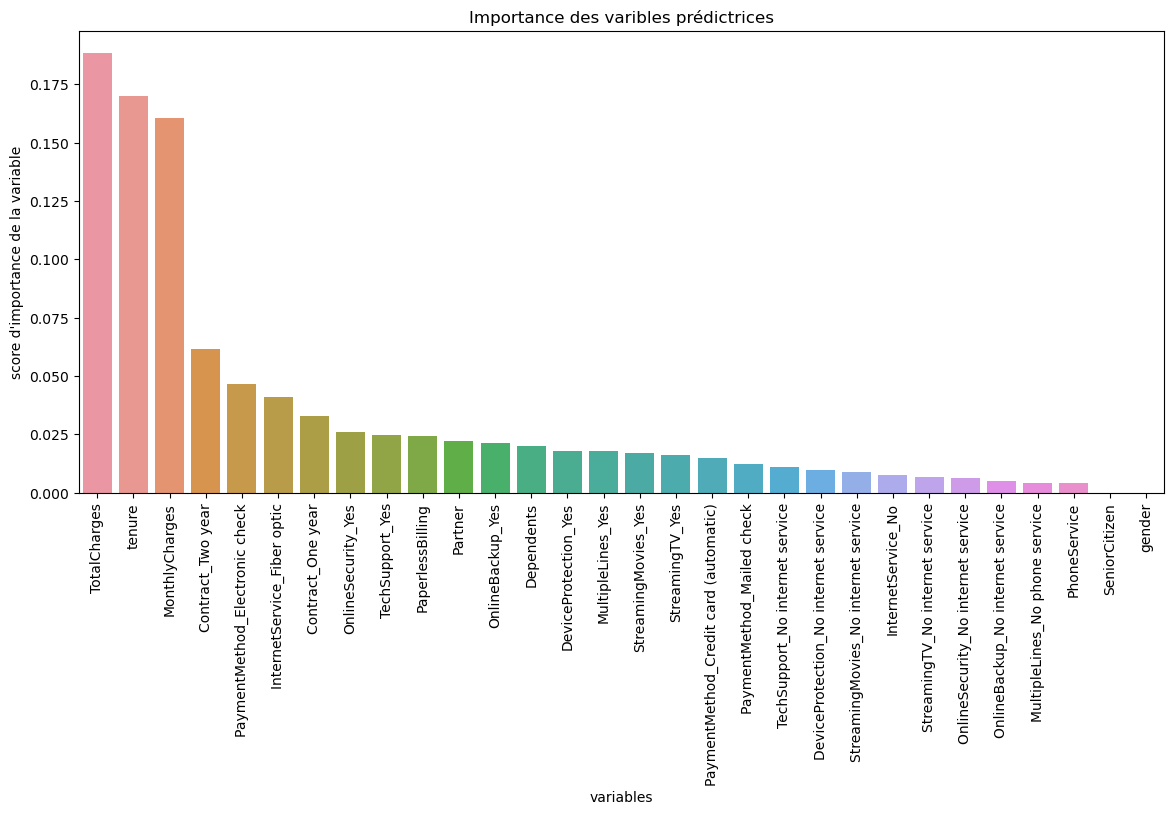

In [274]:
# Importante des variables indépendantes
plt.figure(figsize=(14, 6))
vars_imp= pd.Series(rf.feature_importances_, index=train_features.columns).sort_values(ascending=False)

sns.barplot(x= vars_imp.index, y=vars_imp)
plt.xticks(rotation=90)
plt.xlabel("variables")
plt.ylabel("score d'importance de la variable")
plt.title("Importance des varibles prédictrices")
plt.show()

In [275]:
# Affichage de vars_imp
vars_imp

TotalCharges                             0.188472
tenure                                   0.169982
MonthlyCharges                           0.160670
Contract_Two year                        0.061659
PaymentMethod_Electronic check           0.046520
InternetService_Fiber optic              0.040913
Contract_One year                        0.032704
OnlineSecurity_Yes                       0.025971
TechSupport_Yes                          0.024566
PaperlessBilling                         0.024310
Partner                                  0.022022
OnlineBackup_Yes                         0.021312
Dependents                               0.020279
DeviceProtection_Yes                     0.017819
MultipleLines_Yes                        0.017731
StreamingMovies_Yes                      0.017203
StreamingTV_Yes                          0.016275
PaymentMethod_Credit card (automatic)    0.014975
PaymentMethod_Mailed check               0.012401
TechSupport_No internet service          0.011267


In [ ]:
# on peut aussi modifier ici pour améliorer la performance du modele en choississant un autre seuil par exemple 0.009

In [276]:
# Variables selectionnées pour les algorithmes
seuil=0.004

vars_selected= vars_imp[vars_imp > seuil].index.to_list()

train_features=train_features[vars_selected]

X_val=X_val[vars_selected]

X_test= X_test[vars_selected]

In [277]:
# Nombres de variables prédictrices
len(train_features.columns)

28

Notre objectif est de construire un modèle de classification qui prédit si le client va se désabonner ou non.

Nous utiliserons les différents algorithmes (Logistic regression, Random Forest, Grandient Boosting, Classificateur Perceptron Multicouche
                                            et Support Vecteur Machine) afin de comparer leur performance et de choisir le meilleur modèle.



# MODELE DE REGRESSION LOGISTIQUE

### on peut aussi choisir de règler d'autres hyperparametre pour améliorer la performance du modele

on peut faire pareille pour tous les autres algorithmes

In [292]:
# Dictionnaire des hyperparamètre
param_grid= {"C":[0.001, 0.01, 1, 10, 50, 100, 500]}

# Objet GridSearchCV
grid_logreg_class= GridSearchCV(estimator= LogisticRegression(random_state=seed, max_iter=500),
                                param_grid=param_grid,
                                scoring="f1", 
                                cv=5)
# Entrainement de l'algorithme
logreg_model= grid_logreg_class.fit(train_features, train_labels)

# Meilleur score et meilleur hyperparamètre
print(round(logreg_model.best_score_, 3 ))
print(logreg_model.best_estimator_)

0.789
LogisticRegression(C=10, max_iter=500, random_state=1111)


C'est le C=10 qui donne le meilleur score qui est 0.789.

Le modèle a un bon score d'entrainement.Evaluons sa performance sur les données de validation afin d'apprécier sa capacité à généraliser
sur de nouvelles données.

N.B: pour un scoring="f1" plus le score est proche de 1 plus le modèle a une bonne performance.

In [293]:
# Fonction d'évaluation de la performance du modèle
def model_evaluation(model, features, labels):
    pred=model.predict(features)
    print(classification_report(labels, pred))

In [294]:
# Evaluation du modèle de regression logistique
model_evaluation(logreg_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.75      0.60       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.70      1406
weighted avg       0.79      0.74      0.75      1406



Appliquons l'algorithme # Recursive Feature Eliminator # (RFE) sur le modèle afin de voir s'il garde les memes performances 
lorsqu'on réduit le nombre de prédicteur. En effet, plus le modéle est complexe, plus il est difficile de l'interpréter.

In [297]:
# Création d'une fonction de construction d'un modèle avec l'utilisation de l'algorithme RFE
def model_with_rfe(model):
    rfe_model= RFE(estimator=model, verbose=0)
    rfe_model.fit(train_features, train_labels)
    mask=rfe_model.support_
    reduced_X= train_features.loc[:, mask]
    print(reduced_X.columns)
    return rfe_model
    
 

In [298]:
# Logistic Regression RFE
rfe_logreg_model= model_with_rfe(logreg_model.best_estimator_)

rfe_logreg_model

Index(['TotalCharges', 'tenure', 'MonthlyCharges', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
       'Contract_One year', 'MultipleLines_Yes', 'StreamingMovies_Yes',
       'StreamingTV_Yes', 'DeviceProtection_No internet service',
       'StreamingMovies_No internet service', 'InternetService_No',
       'StreamingTV_No internet service'],
      dtype='object')


RFE(estimator=LogisticRegression(C=10, max_iter=500, random_state=1111))

In [299]:
# Evaluation du modèle de regression logistique avec RFE
model_evaluation(rfe_logreg_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.73      0.81      1032
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1406
   macro avg       0.70      0.75      0.71      1406
weighted avg       0.79      0.74      0.75      1406



La RFE a reduit le nombre de prédicteurs de 28 à 14 et n'a pas amélioré la performance du modèle.

Passons a l'algorithme de foret aléatoire.

# Modèle de foret aléatoire

In [ ]:
# pour améliorer la performance du modele, icion a choisi 2 hyperparamètre, onpeut choisir plus

In [301]:
# Dictionnaire des hyperparamètre
param_grid_rf= {"n_estimators":[ 10, 50, 100, 500, 1000],
             "max_depth":[3 , 5, 10, 20, None]}

# Objet GridSearchCV
grid_rf_class= GridSearchCV(estimator= RandomForestClassifier(random_state=seed),
                                param_grid=param_grid_rf,
                                scoring="f1", 
                                cv=5)
# Entrainement de l'algorithme
rf_model= grid_rf_class.fit(train_features, train_labels)

# Meilleur score et meilleur hyperparamètre
print(round(rf_model.best_score_, 3 ))
print(rf_model.best_estimator_)

0.908
RandomForestClassifier(n_estimators=50, random_state=1111)


In [305]:
# Evaluation du modele de foret aléatoire
model_evaluation(rf_model.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1032
           1       0.56      0.52      0.54       374

    accuracy                           0.77      1406
   macro avg       0.70      0.69      0.69      1406
weighted avg       0.76      0.77      0.76      1406



Comparé aux valeurs du modèle de régression logistique, le modèle de foret aléatoire semble etre le moins efficace.
Appliquons une RFE.

In [306]:
# Random Forest avec RFE
rfe_forest_model= model_with_rfe(rf_model.best_estimator_)
rfe_forest_model

Index(['TotalCharges', 'tenure', 'MonthlyCharges', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
       'Contract_One year', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'PaperlessBilling', 'Partner', 'OnlineBackup_Yes',
       'StreamingMovies_Yes', 'TechSupport_No internet service'],
      dtype='object')


RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=1111))

par défaut l'algorithme RFE réduit de moitié le nombre de prédicteur.

In [307]:
# Evaluation du modele de foret aléatoire avec RFE
model_evaluation(rfe_forest_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1032
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1406
   macro avg       0.70      0.69      0.69      1406
weighted avg       0.76      0.77      0.76      1406



Le modèle avec RFE performe moins.
Au vu de ces valeurs nous rétiendrons le modèle de foret aléatoire obtenu sans RFE.

passons à la construction d'un modèle de réseau de neuronnes artificielle.


# classificateur perceptron multicouche

Il prend beaucoup de temps pour converger(pour afficher, ca utilise la capacité de la machine)

In [ ]:
# MLPClassifier
mlp= MLPClassifier(random_state=seed, max_iter=1000)
parameters={"hidden_layer_size": [(50,),(100,),(200,)], ["identity","logistic","tanh", "relu"],           
           # "activation": ["identity","logistic","tanh", "relu"],
            "learning_rate": ["constant","invscaling","adaptive"]}
mlp_cv= GridSearchCV(mlp, parameters, scoring="f1", cv=5, n_jobs=-1)

mlp_cv.fit(train_features,train_labels)

In [ ]:
# Meilleur score et meilleur hyperparametre
round(mlp_cv.best_score_, 3)

mlp_cv.best_estimator_

In [ ]:
# evaluation du modèle perceptron

model_evaluation(mlp_cv.best_estimator_, X_val, y_val)

En conclusion c'est le modèle de régression logistique qui a une bonne performance f1-score (0.61)<<on veut prédire les clients qui se désabonne et tandis que le  modèle perceptron a un f1-score(0.51) d'après la vidéo 18 J.A(désabonnement des clients). J'ai pas exécuté car ca prend du temps pour afficher.

Passons maintenant à un modele svm( support vecteur machine)

# support vecteur machine

In [ ]:
# support vecteur machine: Classifieur qui trouve l'hyperplan optimal qui maximise la frontière entre deux plans

svm_model= SVC(random_state=seed)

svm_hyp={"kernel": ["linear","rbf"], "C": [0.1, 1.0, 10, 50, 100]}  

svm_cv= GridSearchCV(svm_model,svm_hyp , scoring="f1", cv=5)

svm_cv.fit(train_features, train_labels)

print(round(svm_cv.best_score_, 3))

print(svm_cv.best_estimator_)

In [ ]:
# support vecteur machine: Classifieur qui trouve l'hyperplan optimal qui maximise la frontière entre deux plans

svm_model= SVC(random_state=seed)

svm_hyp={"kernel": ["linear","rbf"], "C": [0.1, 1.0, 10, 50, 100]}  

svm_cv= GridSearchCV(svm_model,svm_hyp , scoring="f1", cv=5)

svm_cv.fit(train_features, train_labels)

print(round(svm_cv.best_score_, 3))

print(svm_cv.best_estimator_)

In [ ]:
# Evaluation du modele SVM
model_evaluation(svm_cv.best_estimator_, X_val, y_val)

In [ ]:
A vu d'oeil le modèle de svm n'est pas plus performant que celui de la regression logistique

# Conclusion

Nous avons utilisé les données d'évaluation pour sélectionner le  meilleur modèle. Ensuite nous évaluerons le meilleur modèle selectionné sur les données de test afin d'apprécier sa performance sur de nouvelles données.Idéalement les performances de ce modèle sur les données d'évaluation et sur les données de test doivent etre idéalement proches.

In [311]:
model_evaluation(logreg_model.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.75      0.60       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.70      1406
weighted avg       0.79      0.74      0.75      1406



In [310]:
# Performance du meilleur modèle sur les données de test.
model_evaluation(logreg_model.best_estimator_, X_test, y_test)

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1033
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407



Fin